In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [19]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

original = pd.read_csv("bank-full.csv", sep=";")
original['y'] = original['y'].apply(lambda x: 1 if x=="yes" else 0)

---

## Findings

- "day" can get encoded or transformed in some way since its not ratio data.  
- "pdays" has "-1" for missing data, otherwise is useful ratio data. Often people get called around quarter, half, full year

---

In [20]:
## convert day column to str so we will get target encoding as below

train['day'] = train['day'].astype(str)
original['day'] = original['day'].astype(str)

In [21]:
## convert 

---

In [ ]:
# Step 1: Concatenate original + synthetic
train = pd.concat([train, original], ignore_index=True)

# Step 2: Categorical columns
cat_cols = original.select_dtypes(include=['object']).columns

# Step 3: Compute target means from original, and map to full train
for col in cat_cols:
    te_map = original.groupby(col)['y'].mean().to_dict()  # mean target per category
    train[col + "_mean"] = train[col].map(te_map)         # apply to full train
    train.drop(columns=[col], inplace=True)

In [ ]:
# create a column for pdays = -1

train['pdays_none'] = train['pdays'] == -1


train['pdays'] = train['pdays'].apply(lambda x: np.nan if x == -1 else x)

In [28]:
train

,id,age,balance,duration,campaign,pdays,previous,y,job_mean,marital_mean,education_mean,default_mean,housing_mean,loan_mean,contact_mean,day_mean,month_mean,poutcome_mean,pdays_none
0,0.0,42,7,117,3,NaN,0,0,0.110570,0.101235,0.105594,0.117961,0.167024,0.126557,0.149189,0.158333,0.110133,0.091615,False
1,1.0,38,514,185,1,NaN,0,0,0.072750,0.101235,0.105594,0.117961,0.167024,0.126557,0.040707,0.098787,0.102228,0.091615,False
2,2.0,36,602,111,2,NaN,0,0,0.072750,0.101235,0.105594,0.117961,0.077000,0.126557,0.040707,0.113636,0.067195,0.091615,False
3,3.0,27,34,10,2,NaN,0,0,0.286780,0.149492,0.105594,0.117961,0.077000,0.126557,0.040707,0.078142,0.067195,0.091615,False
4,4.0,26,889,902,1,NaN,0,1,0.110570,0.101235,0.105594,0.117961,0.077000,0.126557,0.149189,0.164968,0.166478,0.091615,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885628,NaN,51,825,977,3,NaN,0,1,0.110570,0.101235,0.150064,0.117961,0.167024,0.126557,0.149189,0.090768,0.101511,0.091615,True
885629,NaN,71,1729,456,2,NaN,0,1,0.227915,0.119455,0.086265,0.117961,0.167024,0.126557,0.149189,0.090768,0.101511,0.091615,True
885630,NaN,72,5715,1127,5,184.0,3,1,0.227915,0.101235,0.105594,0.117961,0.167024,0.126557,0.149189,0.090768,0.101511,0.647253,False
885631,NaN,57,668,508,4,NaN,0,0,0.072750,0.101235,0.105594,0.117961,0.167024,0.126557,0.134205,0.090768,0.101511,0.091615,True


In [29]:
x_train, x_test, y_train, y_test = train_test_split(train.drop(columns=['y','id']), train['y'], test_size=0.1, random_state=42)

---

In [30]:
# Assuming x_train is your DataFrame of features
categorical_features_names = x_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Make sure 'remainder__MSZoning' is in this list. It should be if its dtype is object.
print("Detected categorical features:", categorical_features_names)

Detected categorical features: []


In [31]:
import json
import optuna

# Load the best parameters from the saved file
try:
    with open("models/optuna_cat1.json", "r") as f:
        best_params = json.load(f)
    print("Successfully loaded best parameters:")
    print(best_params)
except FileNotFoundError:
    print("Error: The file 'best_params.json' was not found.")

Successfully loaded best parameters:
{'depth': 7, 'learning_rate': 0.16242304317665213, 'l2_leaf_reg': 9.784139225596583, 'iterations': 991, 'subsample': 0.6576101811374836}


In [32]:
cat_days_enc = CatBoostClassifier(**best_params, cat_features=categorical_features_names)

cat_days_enc.fit(x_train, y_train)

0:	learn: 0.4567562	total: 84.7ms	remaining: 1m 23s
1:	learn: 0.3390192	total: 156ms	remaining: 1m 17s
2:	learn: 0.2781751	total: 249ms	remaining: 1m 21s
3:	learn: 0.2443233	total: 335ms	remaining: 1m 22s
4:	learn: 0.2256288	total: 424ms	remaining: 1m 23s
5:	learn: 0.2142561	total: 508ms	remaining: 1m 23s
6:	learn: 0.2062273	total: 587ms	remaining: 1m 22s
7:	learn: 0.2007803	total: 662ms	remaining: 1m 21s
8:	learn: 0.1958233	total: 728ms	remaining: 1m 19s
9:	learn: 0.1929545	total: 795ms	remaining: 1m 18s
10:	learn: 0.1908198	total: 875ms	remaining: 1m 17s
11:	learn: 0.1882931	total: 959ms	remaining: 1m 18s
12:	learn: 0.1867786	total: 1.03s	remaining: 1m 17s
13:	learn: 0.1849635	total: 1.1s	remaining: 1m 17s
14:	learn: 0.1837824	total: 1.16s	remaining: 1m 15s
15:	learn: 0.1828435	total: 1.24s	remaining: 1m 15s
16:	learn: 0.1817838	total: 1.32s	remaining: 1m 15s
17:	learn: 0.1811143	total: 1.39s	remaining: 1m 15s
18:	learn: 0.1805626	total: 1.45s	remaining: 1m 14s
19:	learn: 0.1795544	t

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

def objective(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "verbose": 0,
        "depth": trial.suggest_int("depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(x_train, y_train):
        X_train_cv, X_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**params, cat_features=categorical_features_names)
        model.fit(X_train_cv, y_train_cv)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        aucs.append(auc)

    return np.mean(aucs)


In [ ]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)


In [ ]:
optuna_best_model = CatBoostClassifier(**study.best_params, cat_features=categorical_features_names)

In [ ]:
import json

# Your existing Optuna code
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=40)

print("Best Params:", study.best_params)

# Save the best parameters to a JSON file
with open("models/optuna_cat2_targetenc.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best parameters saved to 'best_params.json'")

---

In [47]:
import xgboost as xgb


def objective(trial):
    params = {
        "eval_metric": "auc",
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "reg_lambda": trial.suggest_float("lambda", 0.01, 20.0),
        "reg_alpha": trial.suggest_float("alpha", 0.01, 10.0),
        "gamma": trial.suggest_float("gamma", 0.01, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.01, 10.0),
        "base_score": trial.suggest_float("base_score", 0.000001, 0.999999),
        "tree_method": "auto",
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(x_train, y_train):
        X_train_cv, X_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_cv, y_train_cv, verbose=1)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        aucs.append(auc)

    return np.mean(aucs)


In [48]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-08-08 09:57:05,831] A new study created in memory with name: no-name-fbc6d04f-87e9-4024-9db2-e45dd856fade
[I 2025-08-08 09:59:59,012] Trial 0 finished with value: 0.9623645741627943 and parameters: {'max_depth': 18, 'learning_rate': 0.08000110028456299, 'n_estimators': 893, 'subsample': 0.07252686847449255, 'colsample_bytree': 0.7880444268829786, 'lambda': 4.761552286222321, 'alpha': 9.660749165303995, 'gamma': 8.404902990264166, 'min_child_weight': 8, 'max_delta_step': 7, 'scale_pos_weight': 9.941888872850125, 'base_score': 0.9562363479500936}. Best is trial 0 with value: 0.9623645741627943.
[I 2025-08-08 10:02:18,994] Trial 1 finished with value: 0.9607913443169975 and parameters: {'max_depth': 5, 'learning_rate': 0.10558372989135828, 'n_estimators': 1719, 'subsample': 0.7136514116997805, 'colsample_bytree': 0.17203633612395602, 'lambda': 7.181917364513713, 'alpha': 4.723405936064045, 'gamma': 5.019962438439864, 'min_child_weight': 9, 'max_delta_step': 0, 'scale_pos_weight': 

Best AUC: 0.9693778066156922
Best Params: {'max_depth': 11, 'learning_rate': 0.11054441560306486, 'n_estimators': 968, 'subsample': 0.886000523994339, 'colsample_bytree': 0.8861307860051247, 'lambda': 6.272903605223428, 'alpha': 9.885145393550097, 'gamma': 0.7453177239456863, 'min_child_weight': 4, 'max_delta_step': 9, 'scale_pos_weight': 4.672701653124035, 'base_score': 0.17657410135549562}


In [53]:
optuna_xgb =  xgb.XGBClassifier(max_depth = 11, learning_rate = 0.11054441560306486, n_estimators = 968, subsample = 0.886000523994339, colsample_bytree = 0.8861307860051247, reg_lambda = 6.272903605223428, reg_alpha = 9.885145393550097, gamma = 0.7453177239456863, min_child_weight = 4, max_delta_step = 9, scale_pos_weight = 4.672701653124035, base_score = 0.17657410135549562)

In [51]:
study.best_params

{'max_depth': 11,
 'learning_rate': 0.11054441560306486,
 'n_estimators': 968,
 'subsample': 0.886000523994339,
 'colsample_bytree': 0.8861307860051247,
 'lambda': 6.272903605223428,
 'alpha': 9.885145393550097,
 'gamma': 0.7453177239456863,
 'min_child_weight': 4,
 'max_delta_step': 9,
 'scale_pos_weight': 4.672701653124035,
 'base_score': 0.17657410135549562}

In [54]:
optuna_xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.17657410135549562, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8861307860051247, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.7453177239456863, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11054441560306486,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=9, max_depth=11, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=968, n_jobs=None,
              num_parallel_tree=None, ...)

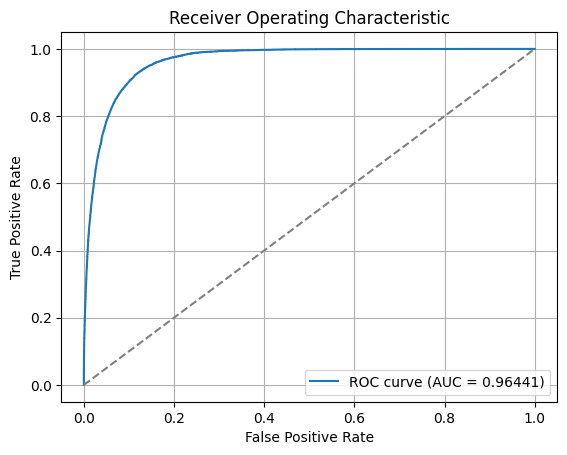

In [55]:
optuna_prob = cat_days_enc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, optuna_prob[:,1])

roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []

for train_idx, valid_idx in cv.split(x_train, y_train):
    X_tr, X_val = x_train.iloc[train_idx], x_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model = xgb.XGBClassifier(**study.best_params)
    model.fit(X_tr, y_tr, verbose=1)
    
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    aucs.append(auc)

final_auc = np.mean(aucs)
print("Final AUC:", final_auc)

Final AUC: 0.9705726758002602


In [64]:
train

,id,age,balance,duration,campaign,pdays,previous,y,job_mean,marital_mean,education_mean,default_mean,housing_mean,loan_mean,contact_mean,day_mean,month_mean,poutcome_mean,pdays_none
0,0.0,42,7,117,3,NaN,0,0,0.110570,0.101235,0.105594,0.117961,0.167024,0.126557,0.149189,0.158333,0.110133,0.091615,False
1,1.0,38,514,185,1,NaN,0,0,0.072750,0.101235,0.105594,0.117961,0.167024,0.126557,0.040707,0.098787,0.102228,0.091615,False
2,2.0,36,602,111,2,NaN,0,0,0.072750,0.101235,0.105594,0.117961,0.077000,0.126557,0.040707,0.113636,0.067195,0.091615,False
3,3.0,27,34,10,2,NaN,0,0,0.286780,0.149492,0.105594,0.117961,0.077000,0.126557,0.040707,0.078142,0.067195,0.091615,False
4,4.0,26,889,902,1,NaN,0,1,0.110570,0.101235,0.105594,0.117961,0.077000,0.126557,0.149189,0.164968,0.166478,0.091615,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885628,NaN,51,825,977,3,NaN,0,1,0.110570,0.101235,0.150064,0.117961,0.167024,0.126557,0.149189,0.090768,0.101511,0.091615,True
885629,NaN,71,1729,456,2,NaN,0,1,0.227915,0.119455,0.086265,0.117961,0.167024,0.126557,0.149189,0.090768,0.101511,0.091615,True
885630,NaN,72,5715,1127,5,184.0,3,1,0.227915,0.101235,0.105594,0.117961,0.167024,0.126557,0.149189,0.090768,0.101511,0.647253,False
885631,NaN,57,668,508,4,NaN,0,0,0.072750,0.101235,0.105594,0.117961,0.167024,0.126557,0.134205,0.090768,0.101511,0.091615,True


In [65]:
model = xgb.XGBClassifier(**study.best_params)

model.fit(train.drop(columns=['y','id']), train['y'])

XGBClassifier(alpha=9.885145393550097, base_score=0.17657410135549562,
              booster=None, callbacks=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8861307860051247,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.7453177239456863, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=6.272903605223428,
              learning_rate=0.11054441560306486, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=9,
              max_depth=11, max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=968, ...)

In [66]:
test

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown
249996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure
249997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success
249998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown


In [67]:
## convert day column to str so we will get target encoding as below

test['day'] = test['day'].astype(str)
original['day'] = original['day'].astype(str)

# Step 1: Concatenate original + synthetic
test = pd.concat([test, original], ignore_index=True)

# Step 2: Categorical columns
cat_cols = original.select_dtypes(include=['object']).columns

# Step 3: Compute target means from original, and map to full train
for col in cat_cols:
    te_map = original.groupby(col)['y'].mean().to_dict()  # mean target per category
    test[col + "_mean"] = test[col].map(te_map)         # apply to full train
    test.drop(columns=[col], inplace=True)
test['pdays_none'] = test['pdays'] == -1


test['pdays'] = test['pdays'].apply(lambda x: np.nan if x == -1 else x)

In [73]:
test_prep = test.drop(columns = ['y']).dropna(subset = ['id'])

test_id = test_prep['id']

probas = model.predict_proba(test_prep.drop(columns = ['id']))

In [74]:
sub_df = pd.DataFrame({'id': test_id, 'y': probas[:,1]})

In [90]:
sub_df.to_csv("submissions/xgb_sub_targetenc.csv")

In [89]:
sub_df.reindex()

,id,y
0,750000,0.001489
1,750001,0.086486
2,750002,0.000331
3,750003,0.000028
4,750004,0.009014
...,...,...
249995,999995,0.000051
249996,999996,0.188738
249997,999997,0.932505
249998,999998,0.000501


In [88]:
pd.read_csv("submissions/cat_optuna_tuned.csv")

,id,y
0,750000,0.003198
1,750001,0.140897
2,750002,0.000168
3,750003,0.000029
4,750004,0.023949
...,...,...
249995,999995,0.000271
249996,999996,0.109660
249997,999997,0.423618
249998,999998,0.000915
